#                                          Crime Detection

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB
from datetime import datetime


<h2> 1.3 Real World / Business Objectives and Constraints </h2>

1. Predict as many tags as possible with high precision and recall.
3. No strict latency constraints.

<h1>2. Machine Learning problem </h1>

<h3> 2.2.1 Type of Machine Learning Problem </h3>

<p> It is a multi-label classification problem  <br>
<b>Multi-label Classification</b>: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document.There are crime charges(labels) for every article description in the dataset. Our tasks is find crime charges for future descriptions.  <br>
__Credit__: http://scikit-learn.org/stable/modules/multiclass.html
</p>

<h3>2.2.2 Performance metric </h3>

<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>

<b>'Macro f1 score': </b><br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
<br>

https://www.kaggle.com/wiki/MeanFScore <br>
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br>
<br>
<b> Hamming loss </b>: The Hamming loss is the fraction of labels that are incorrectly predicted. <br>
https://www.kaggle.com/wiki/HammingLoss <br>

<h1> 3. Exploratory Data Analysis </h1>

<h2> 3.1 Data Loading and Cleaning </h2>

In [21]:
data = pd.read_csv('C:/Users/taxak/Downloads/Preetam1.csv')


df_no_dup = pd.DataFrame(data)

In [22]:
df_no_dup.head()

,Date,Cause,Description
0,"Jul 25, 2011",Abuse,\t\t\tA soldier was arrested by the police on ...
1,"Dec 24, 2011",Abuse,\t\t\tThe Spanish tourist had gone to the accu...
2,"Dec 25, 2011","Abduction, Child Sexual Abuse, Rape",\t\t\tThe 37 yr old accused posed as the Chief...
3,"Dec 25, 2011","Abduction, Child Sexual Abuse, Rape",\t\t\tThe four accused allegedly abducted the ...
4,"Dec 25, 2011",Foeticide/Infanticide,"\t\t\tOn August 31, 2007, social activist and ..."


In [23]:
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Cause"].apply(lambda text: len(text.split(",")))
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

('Time taken to run this cell :', datetime.timedelta(0, 0, 6000))


,Date,Cause,Description,tag_count
0,"Jul 25, 2011",Abuse,\t\t\tA soldier was arrested by the police on ...,1
1,"Dec 24, 2011",Abuse,\t\t\tThe Spanish tourist had gone to the accu...,1
2,"Dec 25, 2011","Abduction, Child Sexual Abuse, Rape",\t\t\tThe 37 yr old accused posed as the Chief...,3
3,"Dec 25, 2011","Abduction, Child Sexual Abuse, Rape",\t\t\tThe four accused allegedly abducted the ...,3
4,"Dec 25, 2011",Foeticide/Infanticide,"\t\t\tOn August 31, 2007, social activist and ...",1


In [24]:
df_no_dup.tag_count.value_counts()

1    3228
2    1987
3     714
Name: tag_count, dtype: int64

In [25]:
import nltk
import string

import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re


from nltk.corpus import stopwords
nltk.download('stopwords') #downloading stopwords

from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('crime'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\taxak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
set([u'all', u'just', u"don't", u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'o', u'don', u'hadn', u'herself', u'll', u'had', u'should', u'to', u'only', u'won', u'under', u'ours', u'has', u"should've", u"haven't", u'do', u'them', u'his', u'very', u"you've", u'they', u'not', u'during', u'now', u'him', u'nor', u"wasn't", u'd', u'did', u'didn', u'this', u'she', u'each', u'further', u"won't", u'where', u"mustn't", u"isn't", u'few', u'because', u"you'd", u'doing', u'some', u'hasn', u"hasn't", u'are', u'our', u'ourselves', u'out', u'what', u'for', u"needn't", u'below', u're', u'does', u"shouldn't", u'above', u'between', u'mustn', u't', u'be', u'we', u'who', u"mightn't", u"doesn't", u'were', u'here', u'shouldn', u'hers', u"aren't", u'by', u'on', u'about', u'couldn', u'of', u"wouldn't", u'against', u's', u'

In [35]:

i=0
str1=' '
final_string=[]

s=''
for sent in df_no_dup['Cause'].values:
    sent = re.sub(r"\s+", "", sent, flags=re.UNICODE)
    #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(sent)
    i+=1

In [36]:
df_no_dup['tags']= final_string

In [37]:
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(','))
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(df_no_dup['tags'])

In [38]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

('Number of data points :', 5929)
('Number of unique tags :', 14)


In [39]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:14])

('Some of the tags we have :', [u'abduction', u'abuse', u'childsexualabuse', u'crime', u'domesticviolence', u'dowryharassment', u'foeticide/infanticide', u'humantrafficking', u'molestation', u'murder', u'other', u'rape', u'sexualharassmentatwork', u'streetharassment'])


<h3> 3.2.3 Number of times a tag appeared </h3>

In [40]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [41]:
#Saving this dictionary to csv files.
if not os.path.isfile('C:/Users/taxak/Downloads/tag_counts_dict_dtm.csv'):
    with open('C:/Users/taxak/Downloads/tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("C:/Users/taxak/Downloads/tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,molestation,270
1,sexual harassment at work,279
2,foeticide/infanticide,27
3,street harassment,108
4,dowry harassment,209


In [42]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

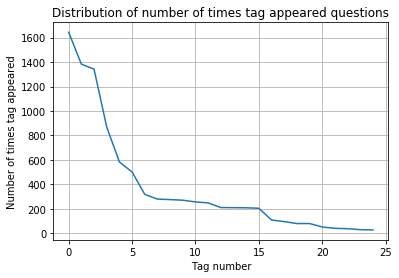

In [43]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

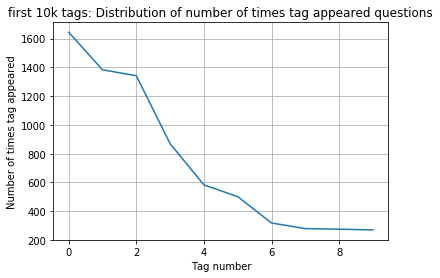

In [44]:
plt.plot(tag_counts[0:10])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()


In [45]:
# Store tags greater than 100 in one list
lst_tags_gt_100 = tag_df[tag_df.Counts>100].Tags
#Print the length of the list
print ('{} Tags are used more than 100 times'.format(len(lst_tags_gt_100)))
# Store tags greater than 1000 in one list
lst_tags_gt_1000 = tag_df[tag_df.Counts>1000].Tags
#Print the length of the list.
print ('{} Tags are used more than 1000 times'.format(len(lst_tags_gt_1000)))

17 Tags are used more than 100 times
3 Tags are used more than 1000 times


<h3> 3.2.4 Tags Per Question </h3>

In [46]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting each value in the 'tag_quest_count' to integer.
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 5929 datapoints.
[1, 1, 3, 3, 1]


In [47]:
print( "Maximum number of tags per description: %d"%max(tag_quest_count))
print( "Minimum number of tags per description: %d"%min(tag_quest_count))
print( "Avg. number of tags per description: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per description: 3
Minimum number of tags per description: 1
Avg. number of tags per description: 1.575982


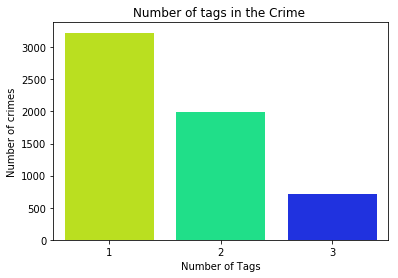

In [48]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the Crime ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of crimes")
plt.show()

<b>Observations:</b><br />
1. Maximum number of tags per crime: 3
2. Minimum number of tags per crime: 1
3. Avg. number of tags per question: 1.57
4. Most of the crimes are having 1 or 2 tags

<h3>3.2.5 Most Frequent Tags </h3>

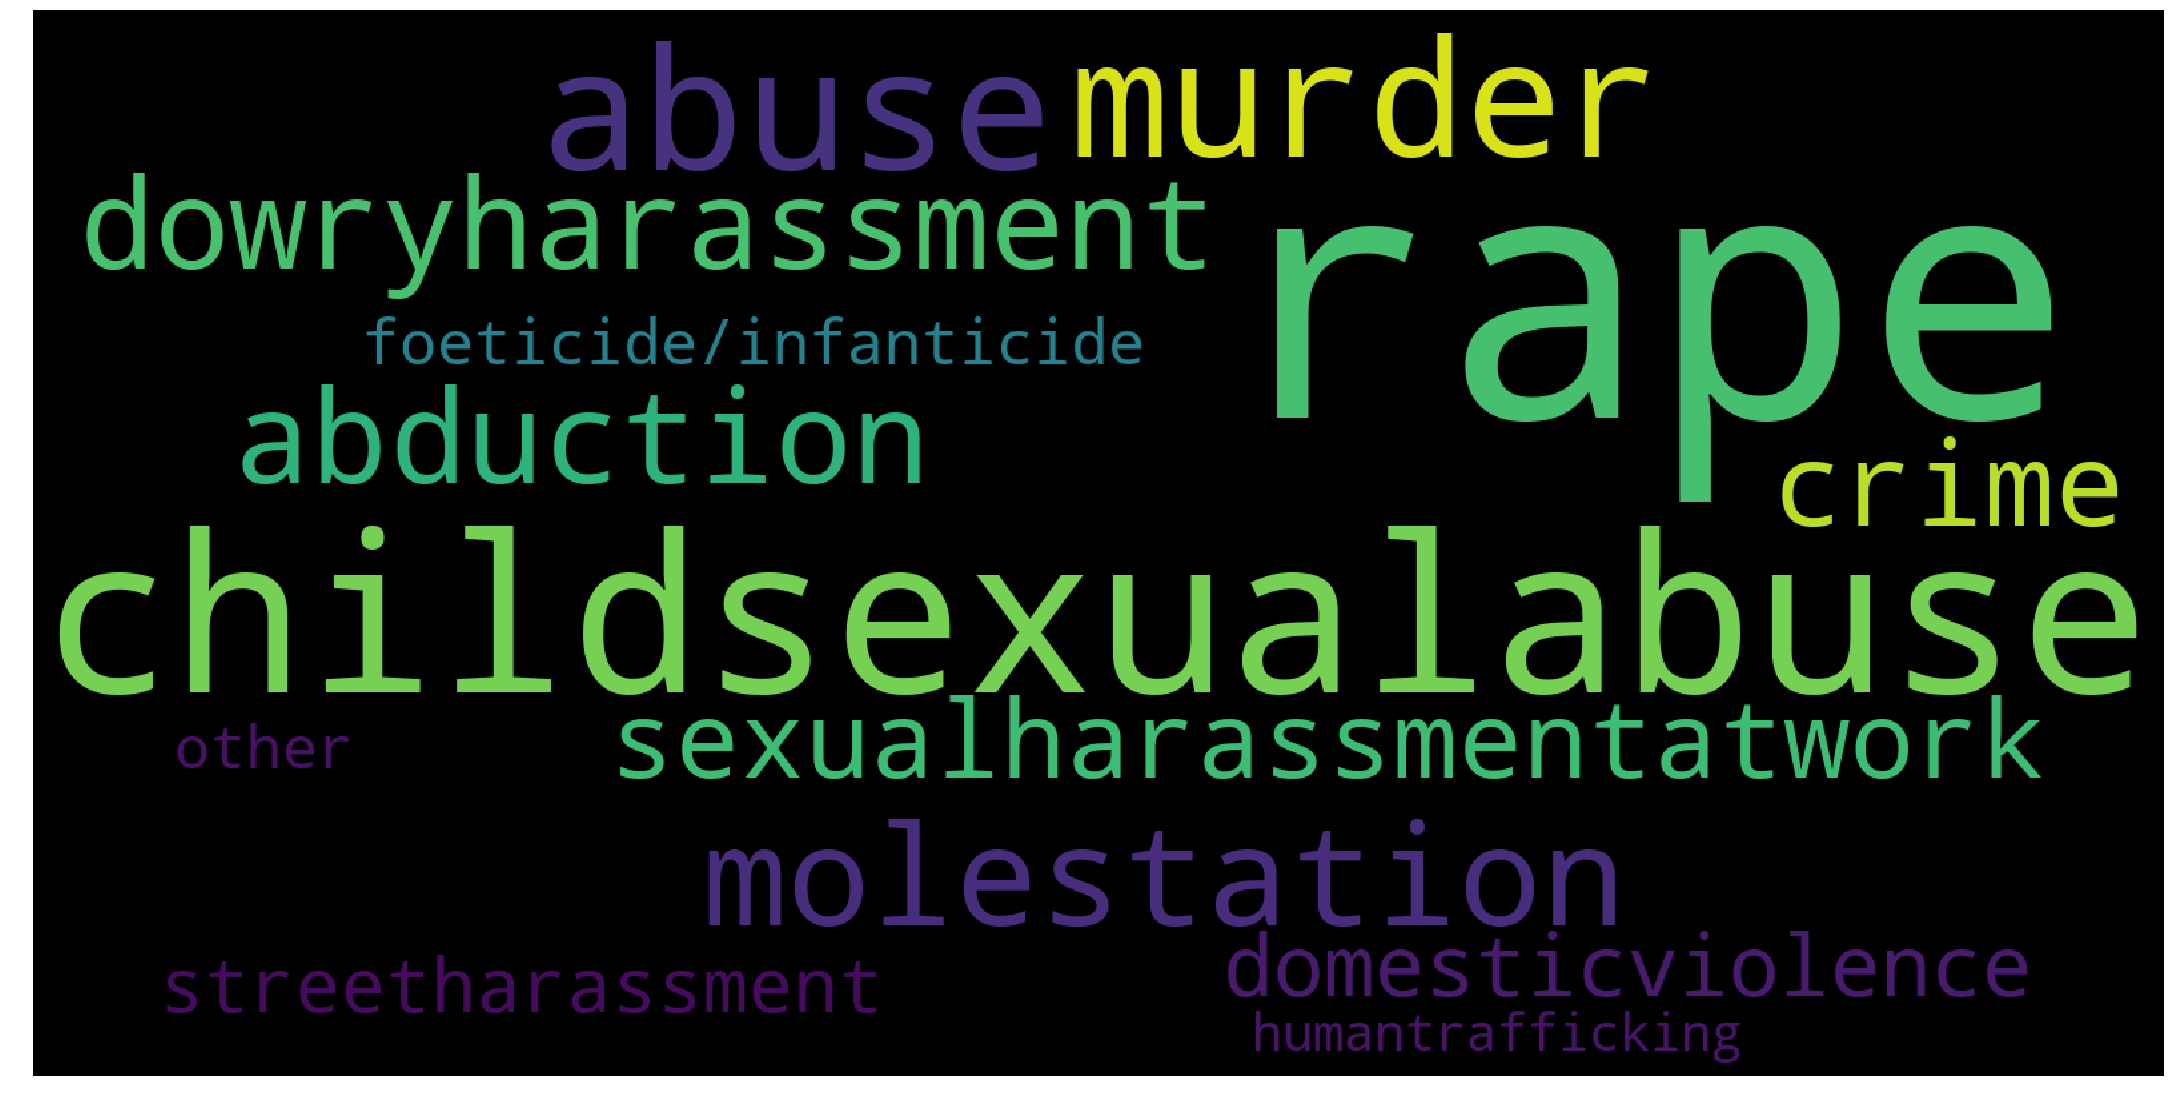

('Time taken to run this cell :', datetime.timedelta(0, 2, 465000))


In [49]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

<b>Observations:</b><br />
A look at the word cloud shows that "rape", "child sexual abuse", "molestation" are some of the most frequent tags.

<h3> 3.2.6 The top 14 tags </h3>

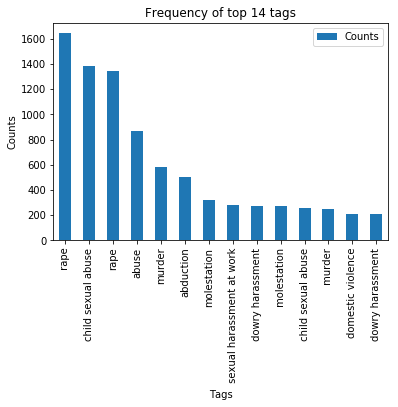

In [51]:
i=np.arange(14)
tag_df_sorted.head(14).plot(kind='bar')
plt.title('Frequency of top 14 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

<h3> 3.3.1 Preprocessing </h3>

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

In [52]:
import nltk
import string

import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re


from nltk.corpus import stopwords
nltk.download('stopwords') #downloading stopwords

from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('crime'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\taxak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
set([u'all', u'just', u"don't", u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'o', u'don', u'hadn', u'herself', u'll', u'had', u'should', u'to', u'only', u'won', u'under', u'ours', u'has', u"should've", u"haven't", u'do', u'them', u'his', u'very', u"you've", u'they', u'not', u'during', u'now', u'him', u'nor', u"wasn't", u'd', u'did', u'didn', u'this', u'she', u'each', u'further', u"won't", u'where', u"mustn't", u"isn't", u'few', u'because', u"you'd", u'doing', u'some', u'hasn', u"hasn't", u'are', u'our', u'ourselves', u'out', u'what', u'for', u"needn't", u'below', u're', u'does', u"shouldn't", u'above', u'between', u'mustn', u't', u'be', u'we', u'who', u"mightn't", u"doesn't", u'were', u'here', u'shouldn', u'hers', u"aren't", u'by', u'on', u'about', u'couldn', u'of', u"wouldn't", u'against', u's', u'

In [53]:
# find sentences containing HTML tags
i=0;
for sent in df_no_dup['Description'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

        

In [54]:

i=0
str1=' '
final_string=[]

s=''
for sent in df_no_dup['Description'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [57]:
df_no_dup['Cleandescription']= final_string

In [58]:
df_no_dup.head()

,Date,Cause,Description,tag_count,tags,Cleandescription
0,"Jul 25, 2011",Abuse,\t\t\tA soldier was arrested by the police on ...,1,Abuse,soldier arrest polic monday baramulla district...
1,"Dec 24, 2011",Abuse,\t\t\tThe Spanish tourist had gone to the accu...,1,Abuse,spanish tourist gone accus kamal pandya yoga c...
2,"Dec 25, 2011","Abduction, Child Sexual Abuse, Rape",\t\t\tThe 37 yr old accused posed as the Chief...,3,"Abduction,ChildSexualAbuse,Rape",old accus pose chief minist secur offic went g...
3,"Dec 25, 2011","Abduction, Child Sexual Abuse, Rape",\t\t\tThe four accused allegedly abducted the ...,3,"Abduction,ChildSexualAbuse,Rape",four accus alleg abduct victim octob sewar vil...
4,"Dec 25, 2011",Foeticide/Infanticide,"\t\t\tOn August 31, 2007, social activist and ...",1,Foeticide/Infanticide,august social activist lawyer varsha deshpand ...


<h1>4. Machine Learning Models </h1>

<h2> 4.1 Converting tags for multilabel problems </h2>

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

In [59]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(','), binary='true')
multilabel_y = vectorizer.fit_transform(df_no_dup['tags'])

In [60]:
print("Number of tags in sample :", multilabel_y.shape[1])


('Number of tags in sample :', 14)


<h2>4.2 Split the data into test and train (80:20) </h2>

In [61]:
total_size= df_no_dup.shape[0]
train_size=int(0.80*total_size)

x_train= df_no_dup.head(train_size)
x_test= df_no_dup.tail(total_size - train_size)

y_train = multilabel_y[0:train_size,:]
y_test = multilabel_y[train_size:total_size,:]

In [62]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

('Number of data points in train data :', (4743, 14))
('Number of data points in test data :', (1186, 14))


<h2>4.3 Featurizing data </h2>

In [63]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['Cleandescription'])
x_test_multilabel = vectorizer.transform(x_test['Cleandescription'])
print("Time taken to run this cell :", datetime.now() - start)


('Time taken to run this cell :', datetime.timedelta(0, 5, 108000))


In [64]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

('Dimensions of train data X:', (4743, 200000), 'Y :', (4743, 14))
('Dimensions of test data X:', (1186, 200000), 'Y:', (1186, 14))


<h2> 4.4 Applying Logistic Regression with OneVsRest Classifier </h2>

In [65]:
# this will be taking so much time try not to run it, download the lr_with_equal_weight.pkl file and use to predict
# This takes about 6-7 hours to run.
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))



('accuracy :', 0.35244519392917367)
('macro f1 score :', 0.48369661484176418)
('micro f1 scoore :', 0.67036934184948627)
('hamming loss :', 0.0714887978800289)


## Word2vec features extractions

In [66]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in df_no_dup['Cleandescription'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [67]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=1,size=50, workers=4)    


In [68]:
words = list(w2v_model.wv.vocab)
print(len(words))

20953


In [69]:
w2v_model.wv.most_similar('drag')

[('insid', 0.955919623374939),
 ('desert', 0.9480065107345581),
 ('gag', 0.9286102056503296),
 ('drove', 0.9238362908363342),
 ('lone', 0.9227816462516785),
 ('push', 0.9166659116744995),
 ('seclud', 0.9149210453033447),
 ('cemeteri', 0.9148237705230713),
 ('bush', 0.9144187569618225),
 ('miscreant', 0.9132415056228638)]

In [70]:
drag = 'drag'
if drag in list_of_sent :
    print(w2v_model[str(drag)])
else :
    print("c")

c


In [71]:
questions = list(df_no_dup['Cleandescription'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [72]:


vecs1 = []

for qu1 in list_of_sent:
    l=len(qu1)
    mean_vec1 = np.zeros([l, 50])
    for word1 in qu1:
        # word2vec
        vec1 = w2v_model[str(word1)]
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df_no_dup['q1_feats_m'] = list(vecs1)



In [73]:
final = df_no_dup

In [74]:
final.head()

,Date,Cause,Description,tag_count,tags,Cleandescription,q1_feats_m
0,"Jul 25, 2011",Abuse,\t\t\tA soldier was arrested by the police on ...,1,Abuse,soldier arrest polic monday baramulla district...,"[-108.377623469, 27.6129242703, 10.7594724633,..."
1,"Dec 24, 2011",Abuse,\t\t\tThe Spanish tourist had gone to the accu...,1,Abuse,spanish tourist gone accus kamal pandya yoga c...,"[-53.1846390143, 38.3533107787, 11.0465429053,..."
2,"Dec 25, 2011","Abduction, Child Sexual Abuse, Rape",\t\t\tThe 37 yr old accused posed as the Chief...,3,"Abduction,ChildSexualAbuse,Rape",old accus pose chief minist secur offic went g...,"[-57.3463398963, 65.4289432317, 15.3711088244,..."
3,"Dec 25, 2011","Abduction, Child Sexual Abuse, Rape",\t\t\tThe four accused allegedly abducted the ...,3,"Abduction,ChildSexualAbuse,Rape",four accus alleg abduct victim octob sewar vil...,"[-44.5417317301, 4.26899052411, -26.9815199822..."
4,"Dec 25, 2011",Foeticide/Infanticide,"\t\t\tOn August 31, 2007, social activist and ...",1,Foeticide/Infanticide,august social activist lawyer varsha deshpand ...,"[-58.34172583, 8.28133374825, -30.4652229622, ..."


In [75]:
df3 = final.drop(['Date','Cause','Description','tag_count','tags','Cleandescription'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)

In [76]:
# Crime tfidf weighted word2vec
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-108.377623,27.612924,10.759472,-27.175979,23.849084,-69.985284,-6.365077,10.286865,81.541368,-56.817929,...,-80.699349,-31.667878,-80.289459,-41.330382,79.177999,-206.355758,-39.820229,23.334614,91.188090,15.642129
1,-53.184639,38.353311,11.046543,-34.038260,25.120121,-51.825743,-29.903737,-8.888979,43.072337,-45.152329,...,-49.826035,-10.903499,-64.596120,-34.790558,66.493658,-133.763938,-18.900908,9.616190,81.780975,4.961737
2,-57.346340,65.428943,15.371109,-30.608959,38.406060,-57.356980,-40.278306,21.731135,12.292802,-57.114014,...,-103.916537,-16.549851,-63.146709,-30.887983,109.764239,-152.360298,-10.777176,7.435535,110.445759,61.178583
3,-44.541732,4.268991,-26.981520,-4.547532,1.302460,1.806881,21.382728,28.825509,25.811866,-23.596778,...,-41.639190,-7.490522,-15.616169,-15.924459,25.215648,-76.267834,-7.235485,0.858719,9.774649,25.565948
4,-58.341726,8.281334,-30.465223,-17.164249,23.242781,-93.101086,-19.956920,11.783335,82.633785,-38.625932,...,-138.843583,-11.872446,-110.933345,-55.772848,31.413245,-106.915412,27.591283,-5.630814,88.273678,63.693886


In [77]:
x_train= df3_q1.head(train_size)
x_test=  df3_q1.tail(total_size - train_size)

In [78]:

classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))



('accuracy :', 0.20657672849915684)
('macro f1 score :', 0.33145074234783667)
('micro f1 scoore :', 0.5582907570831398)
('hamming loss :', 0.1145507106721272)


In [ ]:
from skmultilearn.adapt import MLkNN
classifier = MLkNN(k=21)

# train
classifier.fit(x_train, y_train)

# predict
predictions = classifier.predict(x_test)
print(accuracy_score(y_test,predictions))
print(metrics.f1_score(y_test, predictions, average = 'macro'))
print(metrics.f1_score(y_test, predictions, average = 'micro'))
print(metrics.hamming_loss(y_test,predictions))